In [8]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import networkx as nx
import random
import os

from torch.distributions import Categorical, Bernoulli


import json

from agents.option_critic import OptionCriticFeatures
from agents.option_critic_nn import OptionCriticNeuralNetwork
from agents.option_networks import TerminationFunctionNetwork
from agents.option_networks import ReluNetwork
from agents.option_networks import QNetwork

from utils import utils
import ast

In [10]:
BASE_FOLDER = './evaluations'
N_OPTIONS = 2
TRAFFIC = "custom-2way-single-intersection3"
# MODEL = f"option_critic_nn_100000_steps_curriculum_3_options_custom-2way-single-intersection3_100000_steps"
MODEL = "option_critic_nn_2_options_custom-2way-single-intersection3_50000_steps"
# MODEL = "option_critic_classification_classification_2_options_custom-2way-single-intersection3_50000_steps_queue_based"
# MODEL = "option_critic_nn_curriculum_3_options_custom-2way-single-intersection3_50000_steps_without_option_reward"
# MODEL = "option_critic_classification_classification_2_options_custom-2way-single-intersection3_50000_steps"
# MODEL = "option_critic_nn_curriculum_3_options_custom-2way-single-intersection3_50000_steps_queue_based"
# MODEL = "cyclic_15"
PREFIX = f"{MODEL}_{TRAFFIC}"                                              

In [11]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix):
    with open(f"./meta/{TRAFFIC}.json") as f:
        meta_data = json.load(f)
    # TMP: todo update for multiple traffic lights
    tf_data = list(meta_data.values())[0]

    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    def translate_action(action_dict):
        # TODO: add fix in evaluate script
        action_dict = ast.literal_eval(action_dict)
        if not isinstance(action_dict, dict):
            action_dict = {"t": action_dict[0]}
        green = []
        for tf_id, p in action_dict.items():
            green_tf = f"{tf_id}:"
            green_tf += ", ".join(meta_data[tf_id]["phases"][str(p)]["lanes_green"])
            green.append(green_tf)
        return "; ".join(green)
    
    df_single_episode["translated_action"]= df_single_episode['action'].apply(
        lambda x: translate_action(x)
    )
    
    df_single_episode["translated_lane"]
    
    df_multiple_episodes = None
    # df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def get_obs(df, index):
    current_option = df.option.to_list()[index]
    total_observation = []
    unnested_obs = {}
    
    with open(f"./meta/{TRAFFIC}.json") as f:
        meta_data = json.load(f)
    
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():        
        phase_ids = observation_dict["hist_phase_ids"]
        # min_green = observation_dict["min_green"]
        # density = observation_dict["density"]
        queue = observation_dict["queue"]
        queue_der = observation_dict["queue_der"]
        average_speed = observation_dict["average_speed"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.mean(waiting_time))
            else:
                waiting_times.append(0)
        observation = np.array(phase_ids + queue + queue_der + waiting_times + [average_speed], dtype=np.float32)
        
        # TODO: check if I can update the phase ids?
        # TODO: double check queue_der
        tf_meta_data = meta_data[tf_id]        
        
        total_observation.extend(observation)
        for key, value in observation_dict.items():           
            if isinstance(value, list):
                for index, item in enumerate(value):
                    suffix = index
                    if key in ["queue"]:
                        suffix = tf_meta_data["lanes"]["incoming"][str(index)]
                    unnested_obs[f"{tf_id}_{key}_{suffix}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)
    encoded_option = np.zeros(N_OPTIONS)
    encoded_option[current_option] = 1
    total_observation = np.append(total_observation, encoded_option)
    
    for o in range(N_OPTIONS):
        key = f"option_{o}"
        if o == current_option:
            value = 1
        else:
            value = 0
        unnested_obs[f"{tf_id}_{key}"] = value

    return total_observation, current_option, unnested_obs

def get_random_obs(df):
    index = random.randrange(df.shape[0])
    return get_obs(df, index)

def prep_state(obs, current_option):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)


    # include option information
    # Simplified to make it easier to manage
    encoded_option = np.zeros(N_OPTIONS)
    encoded_option[current_option] = 1
    obs = np.append(obs, encoded_option)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor


In [21]:
with open(f"./meta/{TRAFFIC}.json") as f:
    meta_data = json.load(f)

df_single_episode, _ = load_data(PREFIX)

model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = model_params['Q']
termination_network_params = model_params['terminations']

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")

termination_model.load_state_dict(termination_network_params)

q_model = ReluNetwork(input_size=list(q_model_params.values())[0].shape[1],
                      output_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")

q_model.load_state_dict(q_model_params)

option_policies = {}
for option in range(N_OPTIONS):
    option_policy_model_params = model_params[f'option_policy_{option}']
    option_policy_model = ReluNetwork(input_size=list(option_policy_model_params.values())[0].shape[1],
                      output_size=list(option_policy_model_params.values())[-1].shape[0],
                      device="cpu")
    option_policy_model.load_state_dict(option_policy_model_params)

    option_policies[option] = option_policy_model


/tmp/ipykernel_12036/1486445127.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(


<Axes: xlabel='step'>

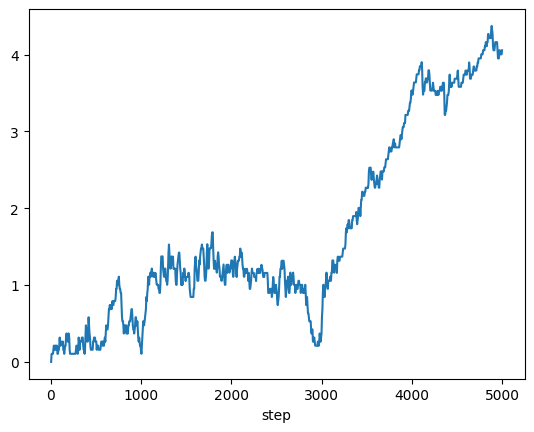

In [13]:
df_single_episode.lane_density.plot()

In [40]:
densities = []
for index in range(df_single_episode.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    density_dict = {}
    with open(f"./meta/{TRAFFIC}.json") as f:
        meta_data = json.load(f)
    lanes = meta_data["t"]["lanes"]["incoming"] # TODO: improve
    for key, value in unnested_dict.items():
        if "density" in key:
            new_key = key[:-1] + lanes[key[-1]]
            density_dict[key] = value
    densities.append(density_dict)
df_densities = pd.DataFrame(densities)

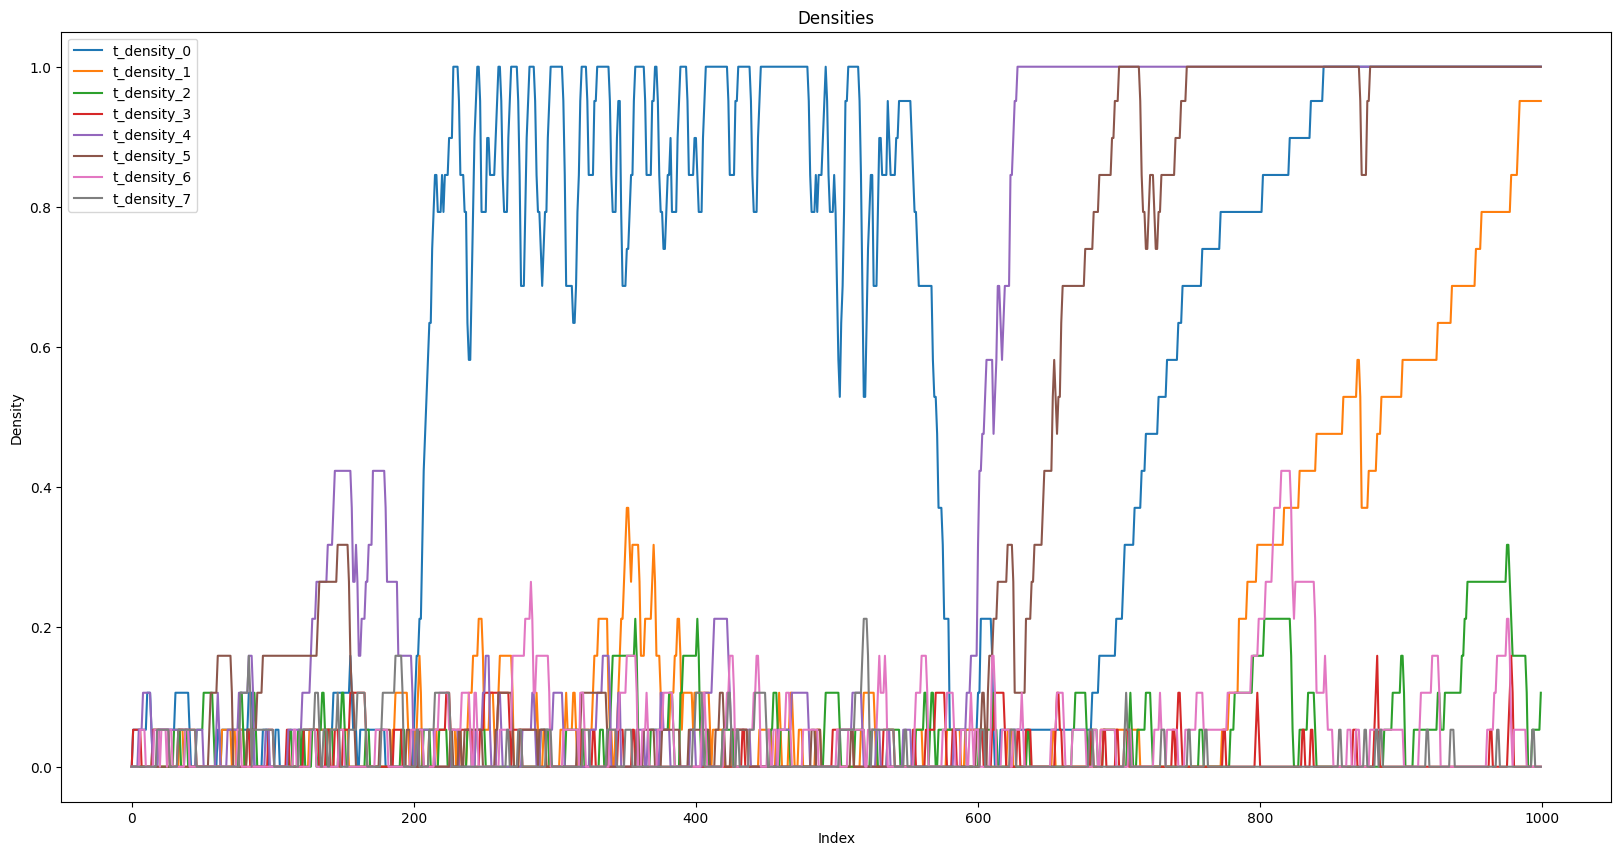

In [41]:
plt.figure(figsize=(20, 10))

for column in df_densities.columns:
    plt.plot(df_densities.index, df_densities[column], label=column)

plt.legend()
plt.title("Densities")
plt.xlabel("Index")
plt.ylabel("Density")
plt.show()

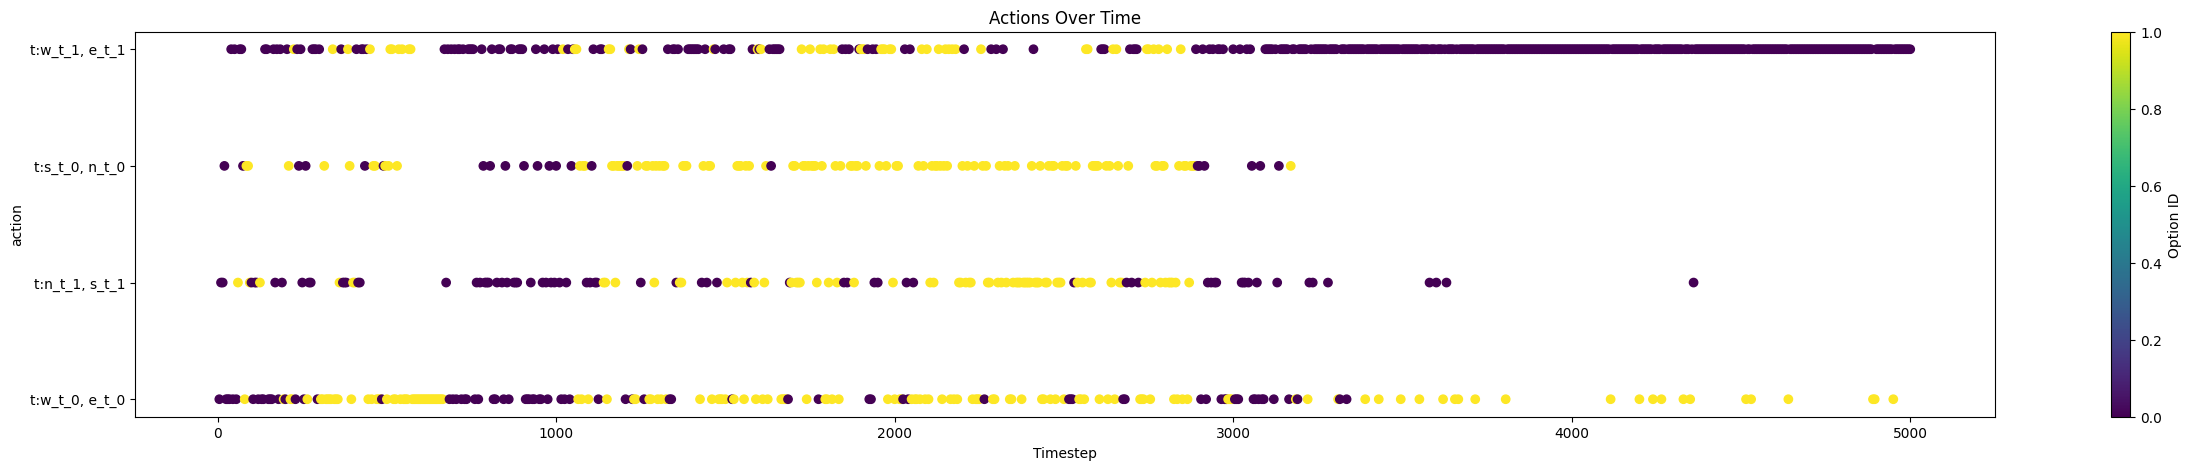

In [20]:
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.translated_action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

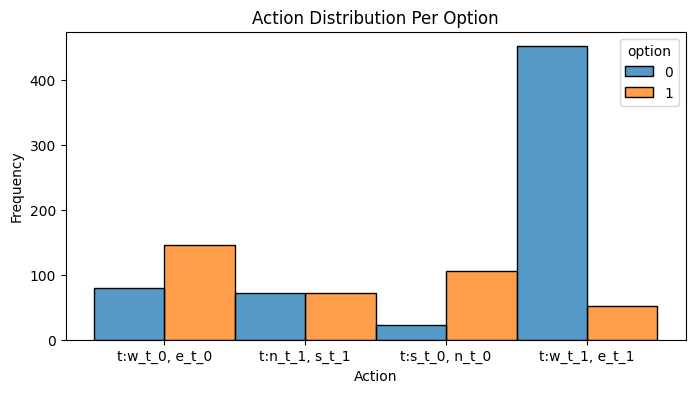

In [17]:
plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="translated_action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

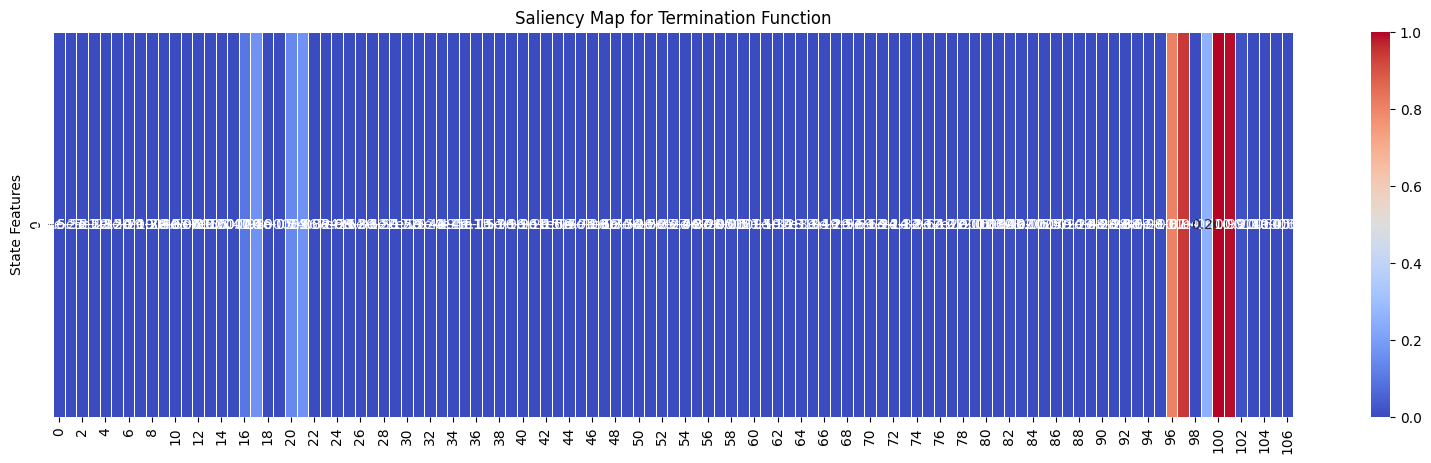

In [18]:
obs, current_option, unnested_dict = get_random_obs(df_single_episode)
state = prep_state(obs, current_option)
state = state.clone().detach().requires_grad_(True)
# Forward pass
termination_prob = termination_model(state)[:, current_option]

# Compute gradients w.r.t input state
termination_prob.backward()

# Get absolute gradient values (saliency)
saliency = state.grad.abs().detach().numpy()

# Normalize for visualization
saliency /= saliency.max()

# Plot saliency map
plt.figure(figsize=(20, 5))
sns.heatmap(saliency.reshape(1, -1), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Saliency Map for Termination Function")
plt.ylabel("State Features")
plt.show()

In [178]:
for index, key in enumerate(unnested_dict):
    print(index, key)

0 t_current_phase_ids_0
1 t_current_phase_ids_1
2 t_current_phase_ids_2
3 t_current_phase_ids_3
4 t_hist_phase_ids_0
5 t_hist_phase_ids_1
6 t_hist_phase_ids_2
7 t_hist_phase_ids_3
8 t_hist_phase_ids_4
9 t_hist_phase_ids_5
10 t_hist_phase_ids_6
11 t_hist_phase_ids_7
12 t_hist_phase_ids_8
13 t_hist_phase_ids_9
14 t_hist_phase_ids_10
15 t_hist_phase_ids_11
16 t_hist_phase_ids_12
17 t_hist_phase_ids_13
18 t_hist_phase_ids_14
19 t_hist_phase_ids_15
20 t_min_green_0
21 t_density_0
22 t_density_1
23 t_density_2
24 t_density_3
25 t_density_4
26 t_density_5
27 t_density_6
28 t_density_7
29 t_queue_0
30 t_queue_1
31 t_queue_2
32 t_queue_3
33 t_queue_4
34 t_queue_5
35 t_queue_6
36 t_queue_7
37 t_queue_der_0
38 t_queue_der_1
39 t_queue_der_2
40 t_queue_der_3
41 t_queue_der_4
42 t_queue_der_5
43 t_queue_der_6
44 t_queue_der_7
45 t_queue_der_8
46 t_queue_der_9
47 t_queue_der_10
48 t_queue_der_11
49 t_queue_der_12
50 t_queue_der_13
51 t_queue_der_14
52 t_queue_der_15
53 t_queue_der_16
54 t_queue_der_

In [208]:
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
#     print(index, json.dumps(unnested_dict, indent=4))
    state = prep_state(obs, current_option)
    print("==============")
    print(index * 5, "option", current_option, "termination prob", df_single_episode.termination_prob.to_list()[index], "\n", 
          "Q", q_model(state),
          "\n", "termination", termination_model(state))
    for option, policy in option_policies.items():
        raw_action_dist = policy(state)
        action_dist = Categorical(logits=raw_action_dist)
        action = action_dist.sample()
        print("Option", option, "action", action, "\n", "raw_action_dist", raw_action_dist,"\n", "action_dist", action_dist.probs)


0 option 2 termination prob 0.5134400129318237 
 Q tensor([[0.2889, 0.2840, 0.2317]], grad_fn=<AddmmBackward0>) 
 termination tensor([[0.0722, 0.0019, 0.0538]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([3]) 
 raw_action_dist tensor([[ 0.0272, -0.0338, -0.0106, -0.0049]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2582, 0.2430, 0.2487, 0.2501]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([2]) 
 raw_action_dist tensor([[ 0.0633, -0.0062,  0.0035,  0.0326]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2601, 0.2426, 0.2450, 0.2522]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 0.0170, -0.0349, -0.0175, -0.0410]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2591, 0.2460, 0.2503, 0.2445]], grad_fn=<SoftmaxBackward0>)
5 option 2 termination prob 0.5134410262107849 
 Q tensor([[0.3012, 0.2966, 0.2422]], grad_fn=<AddmmBackward0>) 
 termination tensor([[0.0722, 0.0019, 0.0538]], grad_fn=<AddmmBackward0>)
Option 0 actio

Option 0 action tensor([0]) 
 raw_action_dist tensor([[0.1900, 0.6658, 0.2342, 0.5644]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1957, 0.3150, 0.2046, 0.2846]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([1]) 
 raw_action_dist tensor([[-0.0959,  0.2032,  0.3350,  0.3575]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1831, 0.2470, 0.2818, 0.2882]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 0.4793, -0.3117, -0.9365, -0.8184]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.5078, 0.2302, 0.1233, 0.1387]], grad_fn=<SoftmaxBackward0>)
205 option 0 termination prob 0.9501226544380188 
 Q tensor([[0.9533, 0.9409, 0.8731]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 3.4050, -0.1671,  0.8930]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[0.2614, 0.7885, 0.2669, 0.6545]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1930, 0.3270, 0.1941, 0.2860]], grad_fn=<SoftmaxBackward0>)


Option 1 action tensor([0]) 
 raw_action_dist tensor([[0.0995, 0.0032, 0.0409, 0.0378]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2637, 0.2395, 0.2487, 0.2480]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([3]) 
 raw_action_dist tensor([[-0.0202,  0.1633, -0.1970, -0.1036]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2526, 0.3034, 0.2116, 0.2324]], grad_fn=<SoftmaxBackward0>)
430 option 0 termination prob 0.5774911642074585 
 Q tensor([[0.5578, 0.5670, 0.4358]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 0.4285, -0.0170,  0.3086]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([2]) 
 raw_action_dist tensor([[-0.0221,  0.2150, -0.1099, -0.1257]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2448, 0.3103, 0.2242, 0.2207]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([2]) 
 raw_action_dist tensor([[ 0.0332, -0.0114,  0.1717,  0.0385]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2433, 0.2327, 0.2794, 0.2446]], grad_fn=<SoftmaxBackward

 action_dist tensor([[0.1861, 0.2754, 0.4557, 0.0828]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([2]) 
 raw_action_dist tensor([[ 0.6474, -0.3445, -0.4908,  0.3790]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.4072, 0.1510, 0.1305, 0.3113]], grad_fn=<SoftmaxBackward0>)
685 option 1 termination prob 0.4402504563331604 
 Q tensor([[3.8327, 3.8789, 3.8011]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 6.1697, -0.2408,  2.0290]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 0.1081,  0.8899, -0.9980, -0.6539]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2511, 0.5487, 0.0831, 0.1172]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[0.9555, 1.1982, 0.9192, 0.0481]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2745, 0.3499, 0.2647, 0.1108]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([1]) 
 raw_action_dist tensor([[ 0.6670, -0.6484, -0.5633,  0.5020]], grad_fn=<AddmmBackward0

Option 0 action tensor([3]) 
 raw_action_dist tensor([[ 0.6585,  1.6593, -1.2594,  1.4492]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1647, 0.4480, 0.0242, 0.3631]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[ 1.5837,  0.2367, -0.0784,  1.2923]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.4552, 0.1184, 0.0864, 0.3401]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 0.4760, -0.5170,  0.2557,  0.0674]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.3524, 0.1306, 0.2828, 0.2342]], grad_fn=<SoftmaxBackward0>)
895 option 1 termination prob 0.4637733995914459 
 Q tensor([[2.3805, 2.6364, 1.4422]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 2.8131, -0.1625,  0.0483]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([3]) 
 raw_action_dist tensor([[ 0.6762,  1.6569, -1.3634,  1.7897]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1462, 0.3897, 0.0190, 0.4451]], grad_fn=<SoftmaxBack

 action_dist tensor([[0.9705, 0.0014, 0.0187, 0.0094]], grad_fn=<SoftmaxBackward0>)
1120 option 1 termination prob 0.420158714056015 
 Q tensor([[5.4675, 5.8323, 3.6174]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 6.5944, -0.3246,  1.1057]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([3]) 
 raw_action_dist tensor([[ 1.6116,  6.2050, -2.6352,  5.4083]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[6.9251e-03, 6.8442e-01, 9.9105e-05, 3.0856e-01]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[ 3.0818, -0.4560,  1.2132,  3.9226]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2856, 0.0083, 0.0441, 0.6620]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 3.4511, -3.2658, -0.7628, -1.2986]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.9759, 0.0012, 0.0144, 0.0084]], grad_fn=<SoftmaxBackward0>)
1125 option 1 termination prob 0.4195437729358673 
 Q tensor([[5.6774, 6.0682, 3.7389]], 

 termination tensor([[ 4.4593, -0.2326,  0.8779]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 1.1189,  2.4826, -1.6421,  1.3312]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1610, 0.6297, 0.0102, 0.1991]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([3]) 
 raw_action_dist tensor([[ 0.2279, -0.3343,  1.1729,  1.3022]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1414, 0.0806, 0.3639, 0.4141]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 1.5076, -0.5973, -0.7376, -0.5758]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.7395, 0.0901, 0.0783, 0.0921]], grad_fn=<SoftmaxBackward0>)
1370 option 1 termination prob 0.4421181380748749 
 Q tensor([[3.1818, 3.4033, 1.9906]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 4.7370, -0.2456,  0.9362]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 0.9334,  2.7431, -1.7141,  1.2167]], grad_fn=<AddmmBackward0>)

 raw_action_dist tensor([[ 0.5389,  2.5147, -2.3764, -0.4792]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1159, 0.8359, 0.0063, 0.0419]], grad_fn=<SoftmaxBackward0>)
1590 option 0 termination prob 0.9238150119781494 
 Q tensor([[7.3208, 6.7817, 6.8428]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 2.7666, -0.1199,  1.7319]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[-0.7871,  2.4613,  0.9360, -0.2603]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.0294, 0.7563, 0.1645, 0.0497]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([2]) 
 raw_action_dist tensor([[1.7638, 0.0261, 2.4245, 0.6909]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.2895, 0.0509, 0.5605, 0.0990]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([1]) 
 raw_action_dist tensor([[ 0.5773,  2.4206, -2.8008, -0.6294]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.1307, 0.8257, 0.0045, 0.0391]], grad_fn=<SoftmaxBackward0>)
1595 option 0 terminatio

 raw_action_dist tensor([[ 0.1914,  6.7875, -7.7408, -4.8989]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.3638e-03, 9.9863e-01, 4.8957e-07, 8.3954e-06]],
       grad_fn=<SoftmaxBackward0>)
1840 option 0 termination prob 0.9998728036880492 
 Q tensor([[14.1192, 12.8915, 13.6319]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 9.0232, -0.3611,  2.0692]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 0.6033,  4.8937,  0.1714, -0.3209]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.0133, 0.9727, 0.0087, 0.0053]], grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([2]) 
 raw_action_dist tensor([[ 6.3005, -0.8873,  7.9847,  3.1288]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.5550e-01, 1.1752e-04, 8.3787e-01, 6.5204e-03]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([1]) 
 raw_action_dist tensor([[ 0.1722,  6.0652, -7.7102, -4.7068]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.7511e-03, 9.9723e-01, 1.0380e-0

 termination tensor([[ 9.6821, -0.3840,  2.0696]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 1.8309,  8.5806, -1.3648, -1.2776]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.1698e-03, 9.9873e-01, 4.7886e-05, 5.2251e-05]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([2]) 
 raw_action_dist tensor([[ 8.6538, -2.5311, 11.7271,  6.2118]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[4.4052e-02, 6.1159e-07, 9.5212e-01, 3.8320e-03]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([1]) 
 raw_action_dist tensor([[  2.0979,  10.5891, -10.1229,  -6.5862]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.0521e-04, 9.9979e-01, 1.0110e-09, 3.4735e-08]],
       grad_fn=<SoftmaxBackward0>)
2075 option 0 termination prob 0.9999376535415648 
 Q tensor([[23.7206, 21.2789, 22.7925]], grad_fn=<AddmmBackward0>) 
 termination tensor([[ 9.7309, -0.3859,  2.0622]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_d

 action_dist tensor([[4.8779e-01, 5.1139e-01, 1.7942e-04, 6.3752e-04]],
       grad_fn=<SoftmaxBackward0>)
2270 option 0 termination prob 0.9999631643295288 
 Q tensor([[21.0976, 20.8639, 20.9954]], grad_fn=<AddmmBackward0>) 
 termination tensor([[10.1163, -0.4011,  1.9657]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 1.7364,  4.4849, -1.6656, -2.9825]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[6.0019e-02, 9.3745e-01, 1.9990e-03, 5.3565e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[ 8.1744, -0.2868,  7.9798,  1.4237]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[5.4810e-01, 1.1593e-04, 4.5114e-01, 6.4126e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([1]) 
 raw_action_dist tensor([[ 1.2733,  1.3870, -7.8952, -5.7850]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[4.7139e-01, 5.2815e-01, 4.9154e-05, 4.0553e-04]],
       grad_fn=<SoftmaxBackward0>)
2275 option 0 te

Option 2 action tensor([0]) 
 raw_action_dist tensor([[  2.0121,  -1.6419, -12.4102,  -4.8962]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.7382e-01, 2.5210e-02, 5.3080e-07, 9.7334e-04]],
       grad_fn=<SoftmaxBackward0>)
2505 option 0 termination prob 0.9999738931655884 
 Q tensor([[29.7941, 29.5815, 29.7243]], grad_fn=<AddmmBackward0>) 
 termination tensor([[10.5404, -0.4164,  1.9282]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[-0.0716,  7.0222, -0.1157, -2.6551]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[8.2883e-04, 9.9832e-01, 7.9306e-04, 6.2585e-05]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[9.6978, 1.3077, 7.0462, 0.7829]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.3379e-01, 2.1207e-04, 6.5870e-02, 1.2547e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[  2.3234,  -1.1412, -12.2654,  -5.2566]], grad_fn=<AddmmBackward0>) 

 action_dist tensor([[5.0574e-10, 1.0000e+00, 7.5441e-09, 2.0370e-09]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[7.0078, 5.5993, 2.0939, 1.0280]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[0.7972, 0.1949, 0.0059, 0.0020]], grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[  2.0939,  -6.0608, -19.1899,  -4.9171]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9881e-01, 2.8705e-04, 5.7022e-10, 9.0086e-04]],
       grad_fn=<SoftmaxBackward0>)
2720 option 1 termination prob 0.3953703045845032 
 Q tensor([[19.2888, 19.4419, 19.3887]], grad_fn=<AddmmBackward0>) 
 termination tensor([[10.7793, -0.4253,  1.8627]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[2.0565e-02, 2.1606e+01, 2.1447e+00, 1.3650e+00]],
       grad_fn=<AddmmBackward0>) 
 action_dist tensor([[4.2205e-10, 1.0000e+00, 3.5308e-09, 1.6190e-09]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tens

 raw_action_dist tensor([[9.3440, 7.8502, 3.6507, 1.0588]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[8.1425e-01, 1.8280e-01, 2.7426e-03, 2.0537e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[  3.3448,  -7.2628, -22.8721,  -6.0324]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9989e-01, 2.4724e-05, 4.1124e-12, 8.4621e-05]],
       grad_fn=<SoftmaxBackward0>)
2955 option 1 termination prob 0.3930953741073608 
 Q tensor([[23.1031, 23.2987, 23.2139]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.0073, -0.4335,  1.8490]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 0.2026, 24.8161,  2.6856,  0.5742]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.0439e-11, 1.0000e+00, 2.4482e-10, 2.9640e-11]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[9.3523, 7.7107, 3.3812, 1.6250]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[8.3566e-01, 1.

Option 1 action tensor([0]) 
 raw_action_dist tensor([[10.4755,  8.9506,  4.6999,  2.7421]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[8.1887e-01, 1.7823e-01, 2.5403e-03, 3.5863e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[  6.2412, -12.6335, -30.9028,  -7.3927]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 6.3506e-09, 7.3886e-17, 1.1991e-06]],
       grad_fn=<SoftmaxBackward0>)
3180 option 1 termination prob 0.39127117395401 
 Q tensor([[27.9750, 28.2285, 28.1567]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.2393, -0.4421,  1.8269]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 2.8967, 34.4363,  1.4942,  3.2082]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.0069e-14, 1.0000e+00, 4.9367e-15, 2.7405e-14]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[10.5818,  8.9154,  4.8394,  2.7266]], grad_fn=<AddmmBackward0>) 
 

 Q tensor([[33.4728, 33.5334, 33.6761]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3285, -0.4455,  1.8186]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 6.7892, 42.8851, -0.4216,  6.1242]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.1076e-16, 1.0000e+00, 1.5566e-19, 1.0838e-16]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[15.8917,  7.2353,  7.3278,  6.9400]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9951e-01, 1.7392e-04, 1.9079e-04, 1.2945e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 11.3498, -21.6827, -35.4997,  -7.6379]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 4.5099e-15, 4.5031e-21, 5.6724e-09]],
       grad_fn=<SoftmaxBackward0>)
3425 option 2 termination prob 0.8603969812393188 
 Q tensor([[33.5988, 33.6611, 33.8035]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3296, -0.4455,  1.8185]], 

 raw_action_dist tensor([[20.5353,  6.6828,  7.8177, 12.1449]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9977e-01, 9.6349e-07, 2.9972e-06, 2.2699e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 14.9613, -29.0898, -40.1304,  -9.1445]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 7.3936e-20, 1.1857e-24, 3.3962e-11]],
       grad_fn=<SoftmaxBackward0>)
3670 option 2 termination prob 0.8601213693618774 
 Q tensor([[38.7138, 38.5607, 38.9407]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3610, -0.4467,  1.8163]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[ 9.7597, 50.8319, -1.3445, 12.5192]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.4540e-18, 1.0000e+00, 2.1881e-23, 2.2962e-17]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[20.5972,  6.6548,  7.8330, 12.2341]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9976

Option 0 action tensor([1]) 
 raw_action_dist tensor([[11.2660, 52.2669, -2.2224,  8.6349]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.5615e-18, 1.0000e+00, 2.1657e-24, 1.1242e-19]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[17.8407,  6.3747,  9.1958,  8.7359]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9970e-01, 1.0476e-05, 1.7596e-04, 1.1109e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 13.8334, -29.3540, -41.3687, -10.3786]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 1.7537e-19, 1.0617e-24, 3.0541e-11]],
       grad_fn=<SoftmaxBackward0>)
3830 option 2 termination prob 0.8600494265556335 
 Q tensor([[40.1373, 40.2929, 40.4051]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3690, -0.4470,  1.8157]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[11.1621, 52.3389, -2.2497,  8.6519]], grad_fn=<AddmmBackward0>) 

Option 1 action tensor([0]) 
 raw_action_dist tensor([[20.9608,  7.3874,  8.5542, 11.5439]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9991e-01, 1.2739e-06, 4.0914e-06, 8.1330e-05]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 15.1888, -33.1062, -42.9874, -11.4230]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 1.0611e-21, 5.4249e-26, 2.7711e-12]],
       grad_fn=<SoftmaxBackward0>)
4005 option 2 termination prob 0.8600255250930786 
 Q tensor([[41.6138, 41.6598, 41.8807]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3725, -0.4471,  1.8155]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[11.8070, 54.4928, -0.5486, 11.8722]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.8960e-19, 1.0000e+00, 1.2468e-24, 3.0910e-19]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[21.0581,  7.3284,  8.5572, 11.6278]], grad_fn=<AddmmBackward0>) 

 raw_action_dist tensor([[19.4729,  7.1326,  8.8886, 10.0622]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9989e-01, 4.3718e-06, 2.5308e-05, 8.1834e-05]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 14.6566, -31.9968, -43.8011, -11.4517]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 5.4788e-21, 4.0940e-26, 4.5849e-12]],
       grad_fn=<SoftmaxBackward0>)
4245 option 2 termination prob 0.8600239157676697 
 Q tensor([[41.8662, 41.9858, 42.1445]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3735, -0.4472,  1.8155]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[11.5363, 54.9999, -1.6340, 10.4731]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.3306e-19, 1.0000e+00, 2.5365e-25, 4.5947e-20]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[19.5573,  7.1766,  8.8494, 10.1111]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9989

4490 option 2 termination prob 0.8600238561630249 
 Q tensor([[42.6492, 42.7043, 42.9169]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3737, -0.4472,  1.8155]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[12.5209, 55.2607,  0.1054, 14.9076]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.7437e-19, 1.0000e+00, 1.1127e-24, 2.9845e-18]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[22.2743,  9.0903,  7.7560, 12.8008]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9992e-01, 1.8803e-06, 4.9516e-07, 7.6855e-05]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 14.8728, -34.9188, -44.6229, -12.0420]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 2.3757e-22, 1.4499e-26, 2.0467e-12]],
       grad_fn=<SoftmaxBackward0>)
4495 option 2 termination prob 0.8600238561630249 
 Q tensor([[42.9296, 42.9686, 43.1962]], grad_fn=<AddmmBackward0>) 


 Q tensor([[42.6160, 42.4811, 42.8744]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3737, -0.4472,  1.8155]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[11.9358, 56.0990, -0.4104, 16.1803]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[6.6090e-20, 1.0000e+00, 2.8725e-25, 4.6080e-18]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[23.5378,  7.6929,  7.7816, 14.2654]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9991e-01, 1.3141e-07, 1.4360e-07, 9.3976e-05]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 16.2488, -34.8289, -44.8370, -11.4044]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 6.5651e-23, 2.9564e-27, 9.7811e-13]],
       grad_fn=<SoftmaxBackward0>)
4730 option 2 termination prob 0.8600262999534607 
 Q tensor([[42.6393, 42.4975, 42.8972]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3737, -0.4472,  1.8155]], 

Option 0 action tensor([1]) 
 raw_action_dist tensor([[1.2456e+01, 5.5128e+01, 5.2231e-02, 1.5392e+01]],
       grad_fn=<AddmmBackward0>) 
 action_dist tensor([[2.9367e-19, 1.0000e+00, 1.2050e-24, 5.5341e-18]],
       grad_fn=<SoftmaxBackward0>)
Option 1 action tensor([0]) 
 raw_action_dist tensor([[22.7149,  9.2429,  7.1593, 13.5563]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[9.9989e-01, 1.4097e-06, 1.7548e-07, 1.0530e-04]],
       grad_fn=<SoftmaxBackward0>)
Option 2 action tensor([0]) 
 raw_action_dist tensor([[ 15.2516, -35.0465, -44.4406, -12.0063]], grad_fn=<AddmmBackward0>) 
 action_dist tensor([[1.0000e+00, 1.4316e-22, 1.1913e-26, 1.4523e-12]],
       grad_fn=<SoftmaxBackward0>)
4975 option 0 termination prob 0.9999885559082032 
 Q tensor([[43.0231, 43.0935, 43.2946]], grad_fn=<AddmmBackward0>) 
 termination tensor([[11.3737, -0.4472,  1.8155]], grad_fn=<AddmmBackward0>)
Option 0 action tensor([1]) 
 raw_action_dist tensor([[12.2456, 55.3091, -0.2985, 13.7545]], grad_fn

In [154]:
def create_feature_df(df):
    feature_list = []
    option_list = df.option.to_list()
    for index, obs_item in enumerate(df.obs.to_list()):
        unnested_obs = {}
        for tf_id, observation_dict in json.loads(obs_item).items():
            for key, value in observation_dict.items():
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        unnested_obs[f"{tf_id}_{key}_{index}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
        current_option = int(option_list[index])
        for o in range(N_OPTIONS):
            key = f"option_{o}"
            if o == current_option:
                value = 1
            else:
                value = 0
            unnested_obs[f"{tf_id}_{key}"] = value
                    
        feature_list.append(unnested_obs)
    return pd.DataFrame(feature_list)

features = create_feature_df(df_single_episode)

In [155]:
def f(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = termination_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer = shap.KernelExplainer(f, features.iloc[:50, :])
shap_values = explainer.shap_values(features.iloc[:, :], nsamples=50)

  1%|█                                                                                                                                              | 7/1000 [00:03<08:55,  1.85it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=4.980e-07, previous alpha=4.879e-07, with an active set of 25 regressors.
  warnings.warn(
  2%|██▏                                                                                                                                           | 15/1000 [00:08<09:37,  1.71it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.165e-03, with an active set of 5 regressors, and the smallest chole

 11%|███████████████▌                                                                                                                             | 110/1000 [01:03<09:10,  1.62it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.723e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.699e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-pack

 18%|█████████████████████████▌                                                                                                                   | 181/1000 [01:42<07:18,  1.87it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.362e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.133e-05, previous alpha=6.781e-06, with an active set of 23 regressors.
  warnings.warn(
 20%|████████████████████████████                                                  

 37%|████████████████████████████████████████████████████▎                                                                                        | 371/1000 [03:32<06:48,  1.54it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.058e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=7.252e-06, previous alpha=7.252e-06, with an active set of 25 regressors.
  warnings.warn(
 39%|██████████████████████████████████████████████████████▊                       

 46%|█████████████████████████████████████████████████████████████████                                                                            | 461/1000 [04:22<06:36,  1.36it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.527e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=7.633e-05, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 509/1000 [05:22<10:31,  1.29s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.779e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.534e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 606/1000 [06:38<04:53,  1.34it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.178e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.089e-05, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 639/1000 [07:00<04:02,  1.49it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.110e-05, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.201e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-p

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 744/1000 [08:03<02:11,  1.94it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=7.217e-07, previous alpha=7.217e-07, with an active set of 23 regressors.
  warnings.warn(
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 746/1000 [08:04<01:57,  2.17it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=4.128e-07, with an active set of 27 regressors, and the smallest cho

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 797/1000 [08:32<01:58,  1.72it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.270e-05, previous alpha=1.165e-05, with an active set of 21 regressors.
  warnings.warn(
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 815/1000 [08:42<01:38,  1.88it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.071e-06, with an active set of 19 regressors, and the smallest cho

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 857/1000 [09:16<02:35,  1.08s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=2.777e-04, previous alpha=2.427e-04, with an active set of 12 regressors.
  warnings.warn(
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 860/1000 [09:18<01:55,  1.21it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=7.743e-05, with an active set of 18 regressors, and the smallest cho

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 951/1000 [10:20<00:35,  1.37it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.890e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.428e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-pac

In [156]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features)

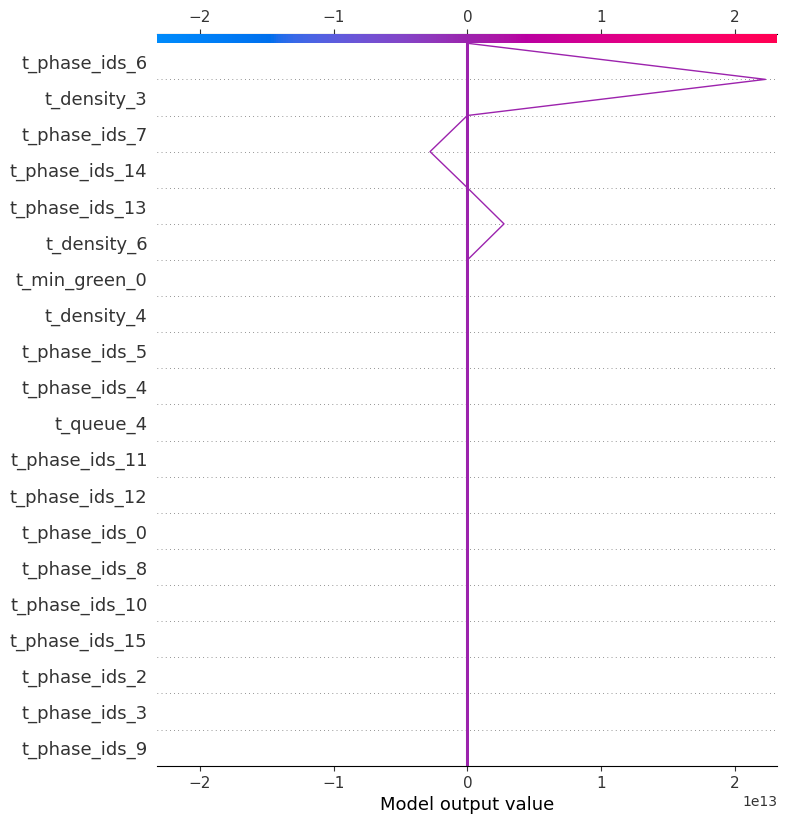

In [157]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values, features)

In [158]:
def f_q_values(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = q_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer_q_model = shap.KernelExplainer(f_q_values, features.iloc[:50, :])
shap_values_q_model = explainer_q_model.shap_values(features.iloc[:, :], nsamples=50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:16<00:00,  1.09it/s]


In [159]:
shap.initjs()
shap.force_plot(shap_values_q_model.expected_value, shap_values_q_model, features)

AttributeError: 'numpy.ndarray' object has no attribute 'expected_value'

In [ ]:
shap.initjs()
shap.decision_plot(shap_values_q_model.expected_value, shap_values_q_model, features)

In [ ]:
##########
# Backup #
##########

In [ ]:
states = df_single_episode.obs.to_list()
options = df_single_episode.option.to_list()
n = df_single_episode.shape[0]
G = nx.DiGraph()

# Add nodes with positions
node_colors = []
for i in range(n):
    G.add_node(states[i], option=options[i])
    node_colors.append(options[i])

# Add directed edges based on actions
for i in range(n - 1):
    G.add_edge(i, i + 1, action=i)

# Draw graph
plt.figure(figsize=(8, 6))
print("Drawing graph")
nx.draw(
    G, with_labels=True,cmap=plt.cm.viridis,
    edge_color="gray", node_size=300, font_size=8, font_color="white",
    arrows=True, arrowsize=10
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)

plt.title("State-Action Network with Termination States")
plt.show()

In [ ]:
model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = {}
termination_network_params = {}

for key, value in model_params.items():
    if key.startswith('Q'):
        q_model_params[key] = value
    elif key.startswith("terminations"):
        termination_network_params[key] = value
    else:
        print(f"Unknown key {key}")

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")
q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")